# River Basin Satellite
https://github.com/uraninjo/SatelliteWaterBodies

In [5]:
!pip install kaggle
api_key = {}
import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_key, file)
    
!kaggle datasets download -d franciscoescobar/satellite-images-of-water-bodies

 97%|██████████████████████████████████████▋ | 239M/247M [00:04<00:00, 86.3MB/s]
100%|████████████████████████████████████████| 247M/247M [00:04<00:00, 53.4MB/s]


In [1]:
!pip install --upgrade opencv-contrib-python
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 MB 21.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 11.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.1/549.1 kB 40.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=f7987349c9207142752ac7b9b00e9f53681315c92daefba35656c2e2c84fa6b2
  Stored in directory: /root/.cache/pip/wheels/22/16/f1/5369d23a06852d5f083d23a1addf0904575f1296f71b412ac8
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60943 sha256=8c3531d710827e4c4396f328b1ca8ae2dbcceff4cf79dd53ae7b9ff0cc98f2b6
  Stored in directory: /root/.cache/pip/wheels/1f/9b/f5/9ccf39b50bc437986145107e2ced70a6fab622cf23e4795aa5
Successfully built eff

In [6]:
from zipfile import ZipFile
import os
for i in os.listdir(os.getcwd()):
    if '.zip' in i:
        print(i)
        with ZipFile(i, 'r') as zipObj:
            zipObj.extractall()
        os.remove(i)

satellite-images-of-water-bodies.zip


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import os
import glob
import cv2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from albumentations import HorizontalFlip, VerticalFlip, Rotate
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.image as mpimg
import albumentations as A

height,width = (256, 256)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
class LoadData(Dataset):
    def __init__(self, images_path, masks_path):
        super().__init__()

        self.images_path = images_path
        self.masks_path = masks_path
        self.len = len(images_path)
        self.transform = A.Compose([
            A.Resize(height,width),
            A.HorizontalFlip(),
            A.RandomBrightnessContrast(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        ])
        

    def __getitem__(self, idx):
        img = Image.open(self.images_path[idx])
        mask = Image.open(self.masks_path[idx]).convert('L')
        
        img,mask=np.array(img),np.array(mask)
        transformed = self.transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

        img = np.transpose(img, (2, 0, 1))
        img = img/255.0
        img = torch.tensor(img)

        mask = np.expand_dims(mask, axis=0)
        mask = mask/255.0
        mask = torch.tensor(mask)

        return img, mask
    
    def __len__(self):
        return self.len

In [3]:
X = sorted(glob.glob(os.getcwd()+"/Water Bodies Dataset/Images/*"))
y = sorted(glob.glob(os.getcwd()+"/Water Bodies Dataset/Masks/*"))
print(len(y), len(X))
assert(len(y)==len(X))


from sklearn.model_selection import train_test_split
# split the training and test dataset into the pytorch Dataset loader
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)
train_dataset = LoadData(X_train, y_train)
valid_dataset = LoadData(X_val, y_val)

2841 2841


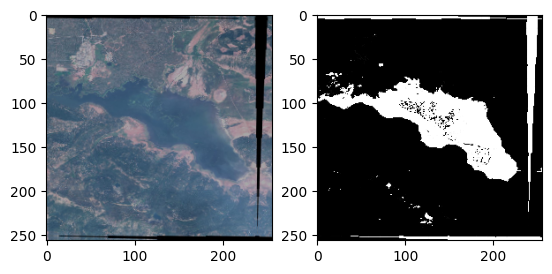

In [4]:
# show what an example image and mask looks like
img, mask = train_dataset[20]

f, axarr = plt.subplots(1,2) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(img.numpy(), (1,2,0)))

In [5]:
# some hyperparameters
epochs = 45
batch_size = 32
learning_rate = 0.001

ratio = 0.5 #Various ratios could perform better for visualization
sample_num = 20

encoder='resnet50'
weights='imagenet'

train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
)

valid_loader = DataLoader(
        dataset=valid_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
)

In [6]:
from torch import nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel,self).__init__()

        self.arc = smp.Unet(
            encoder_name = encoder,
            encoder_weights = weights,
            in_channels = 3,
            classes = 1,
            activation = None
        )
        
    def forward(self,images,masks=None):
        logits=self.arc(images)

        if masks!=None:
            loss1=DiceLoss(mode = 'binary')(logits,masks)
            loss2=nn.BCEWithLogitsLoss()(logits,masks)
            return logits, loss1, loss2
        return logits

model = SegmentationModel()
model.to(device)

SegmentationModel(
  (arc): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReL

In [7]:
def train_fn(data_loader,model,optimizer):
    model.train()
    total_diceloss=0.0
    total_bceloss=0.0
    for images ,masks in tqdm(data_loader):
        images=images.to(device, dtype=torch.float32)
        masks=masks.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        logits,diceloss,bceloss=model(images,masks)
        diceloss.backward(retain_graph=True)
        bceloss.backward()
        optimizer.step()
        total_diceloss+=diceloss.item()
        total_bceloss+=bceloss.item()
        

    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)



def eval_fn(data_loader,model):
    model.eval()
    total_diceloss = 0.0
    total_bceloss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(data_loader):
            images = images.to(device, dtype=torch.float32)
            masks = masks.to(device, dtype=torch.float32)

            logits,diceloss,bceloss = model(images,masks)
            total_diceloss += diceloss.item()
            total_bceloss += bceloss.item()
            
        #Visualization
        for i in range(1):
            image,mask = next(iter(valid_loader))
            image = image[sample_num]
            mask = mask[sample_num]
            logits_mask = model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
            pred_mask = torch.sigmoid(logits_mask)
            pred_mask = (pred_mask > ratio)*1.0
            f, axarr = plt.subplots(1,3) 
            axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
            axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
            axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))
            plt.show()
            
    return total_diceloss/len(data_loader),total_bceloss/len(data_loader)

optimizer=torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


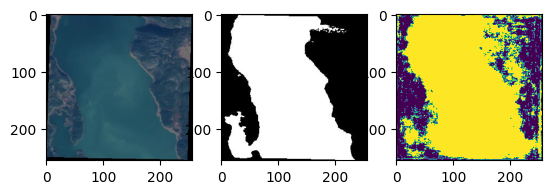

Epochs:1
Train_loss --> Dice: 0.5210306095449548 BCE: 0.5951593122199962 
Valid_loss --> Dice: 0.41323111738477436 BCE: 0.4480283792529787
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.00it/s]


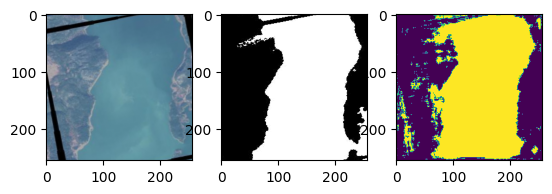

Epochs:2
Train_loss --> Dice: 0.3516679915942644 BCE: 0.40353793807719884 
Valid_loss --> Dice: 0.3232597325529371 BCE: 0.36504462361335754
Model Saved


100%|██████████| 14/14 [00:04<00:00,  2.96it/s]


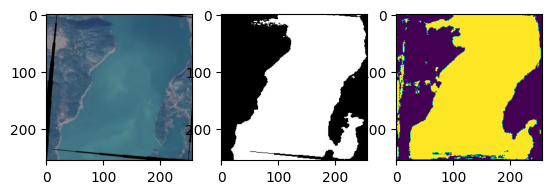

Epochs:3
Train_loss --> Dice: 0.28973330165210526 BCE: 0.35587245265119954 
Valid_loss --> Dice: 0.2771822512149811 BCE: 0.33506245272500174
Model Saved


100%|██████████| 14/14 [00:04<00:00,  2.98it/s]


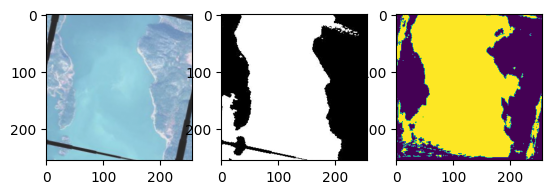

Epochs:4
Train_loss --> Dice: 0.26246829174066844 BCE: 0.3360550131060575 
Valid_loss --> Dice: 0.2608721767153059 BCE: 0.32197789209229605
Model Saved


100%|██████████| 14/14 [00:04<00:00,  2.86it/s]


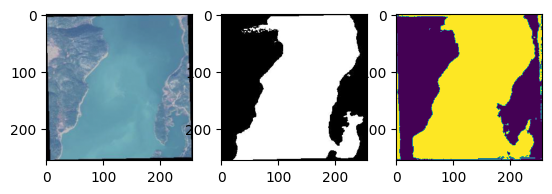

Epochs:5
Train_loss --> Dice: 0.24511019571831352 BCE: 0.3130471706390381 
Valid_loss --> Dice: 0.252990654536656 BCE: 0.32165987683194025
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.13it/s]


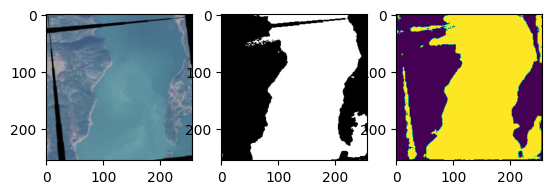

Epochs:6
Train_loss --> Dice: 0.23192961121860303 BCE: 0.3036289881718786 
Valid_loss --> Dice: 0.23757176314081466 BCE: 0.30329312064817976
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.18it/s]


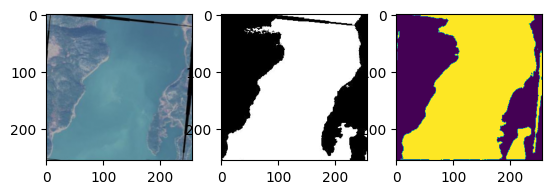

Epochs:7
Train_loss --> Dice: 0.2234746366739273 BCE: 0.29471688815637637 
Valid_loss --> Dice: 0.2360852701323373 BCE: 0.3000592387148312
Model Saved


100%|██████████| 14/14 [00:04<00:00,  2.85it/s]


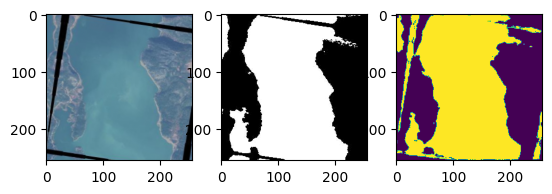

Epochs:8
Train_loss --> Dice: 0.21704843248191633 BCE: 0.2845470703354007 
Valid_loss --> Dice: 0.23282588379723684 BCE: 0.29818143802029745
Model Saved


100%|██████████| 14/14 [00:04<00:00,  2.83it/s]


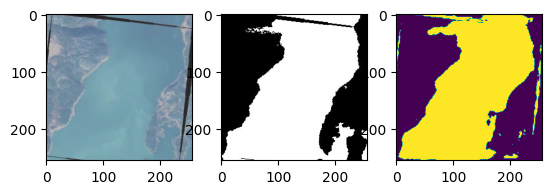

Epochs:9
Train_loss --> Dice: 0.20976465783621134 BCE: 0.27627033818709223 
Valid_loss --> Dice: 0.24365180730819702 BCE: 0.31081894040107727


100%|██████████| 14/14 [00:04<00:00,  2.96it/s]


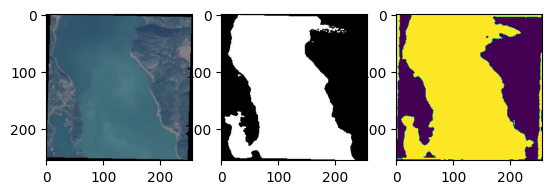

Epochs:10
Train_loss --> Dice: 0.20512881953465312 BCE: 0.270402407567752 
Valid_loss --> Dice: 0.21860745549201965 BCE: 0.28046115913561415
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.04it/s]


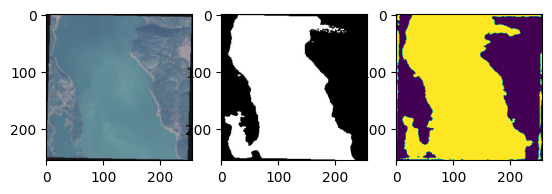

Epochs:11
Train_loss --> Dice: 0.19695440013157695 BCE: 0.2595999046768013 
Valid_loss --> Dice: 0.21666509764535086 BCE: 0.2802086036120142
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


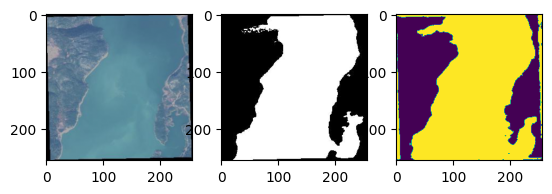

Epochs:12
Train_loss --> Dice: 0.1907064687264593 BCE: 0.2543507224242938 
Valid_loss --> Dice: 0.21466165781021118 BCE: 0.2828124335833958
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


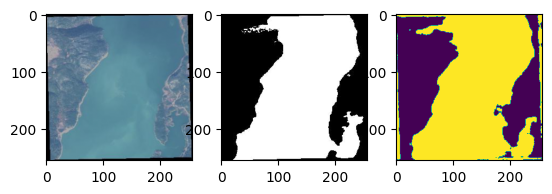

Epochs:13
Train_loss --> Dice: 0.1877488486076656 BCE: 0.2519276234272279 
Valid_loss --> Dice: 0.20866395320211137 BCE: 0.2744109428354672
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.03it/s]


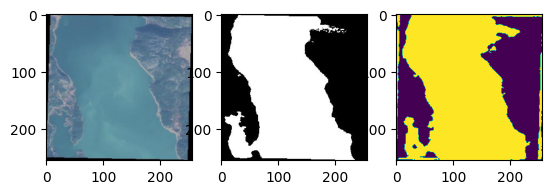

Epochs:14
Train_loss --> Dice: 0.18071956854117543 BCE: 0.2417958600348548 
Valid_loss --> Dice: 0.21192845702171326 BCE: 0.2813010247690337


100%|██████████| 14/14 [00:04<00:00,  3.00it/s]


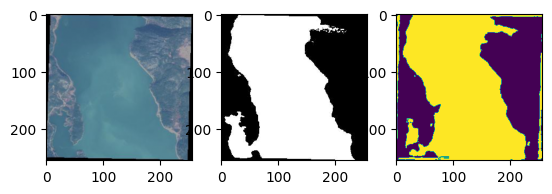

Epochs:15
Train_loss --> Dice: 0.1775055362990028 BCE: 0.23808588264019867 
Valid_loss --> Dice: 0.20588779875210353 BCE: 0.2811208739876747
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.03it/s]


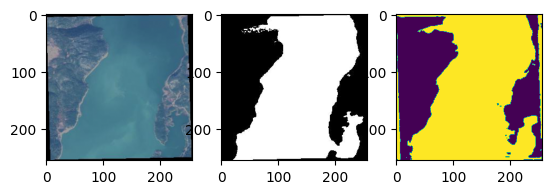

Epochs:16
Train_loss --> Dice: 0.17698752880096436 BCE: 0.23577730259612986 
Valid_loss --> Dice: 0.20079572711672103 BCE: 0.267852070076125
Model Saved


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


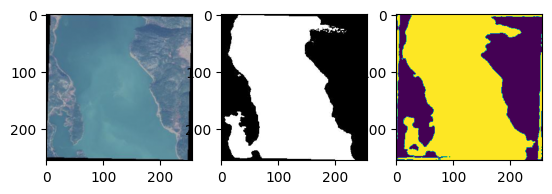

Epochs:17
Train_loss --> Dice: 0.1714964791348106 BCE: 0.2308363704697082 
Valid_loss --> Dice: 0.2031319694859641 BCE: 0.27425940121923176


100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


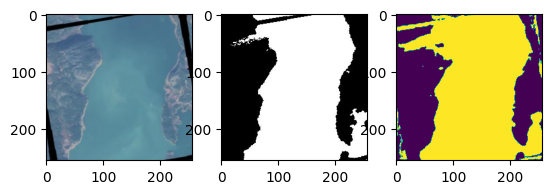

Epochs:18
Train_loss --> Dice: 0.1696803867816925 BCE: 0.2274740571646314 
Valid_loss --> Dice: 0.19885772892407008 BCE: 0.26576179904597147
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.08it/s]


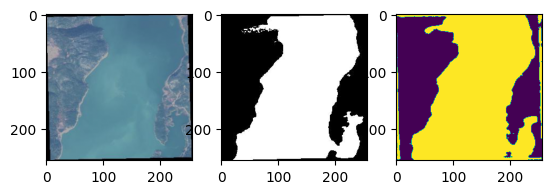

Epochs:19
Train_loss --> Dice: 0.1654468414030577 BCE: 0.22272503846570066 
Valid_loss --> Dice: 0.19890096357890538 BCE: 0.27363356202840805


100%|██████████| 14/14 [00:04<00:00,  3.13it/s]


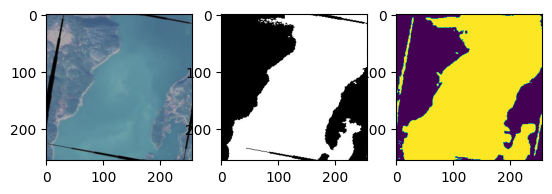

Epochs:20
Train_loss --> Dice: 0.1621189423297581 BCE: 0.21803357883503563 
Valid_loss --> Dice: 0.19465006249291555 BCE: 0.28010744814361843
Model Saved


100%|██████████| 14/14 [00:04<00:00,  2.89it/s]


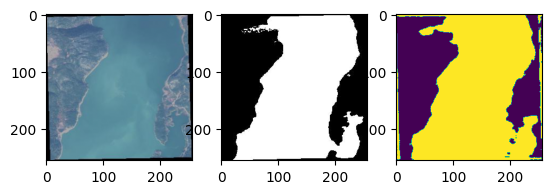

Epochs:21
Train_loss --> Dice: 0.1612340658903122 BCE: 0.21844761622579476 
Valid_loss --> Dice: 0.1876673357827323 BCE: 0.26506414051566807
Model Saved


100%|██████████| 14/14 [00:05<00:00,  2.61it/s]


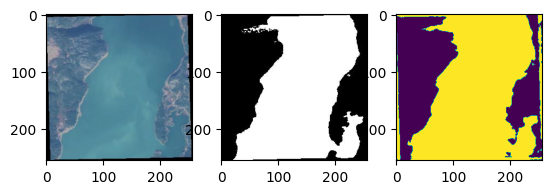

Epochs:22
Train_loss --> Dice: 0.16148312154569125 BCE: 0.21790871514301552 
Valid_loss --> Dice: 0.19064409817968095 BCE: 0.27478927480322973


100%|██████████| 14/14 [00:04<00:00,  2.99it/s]


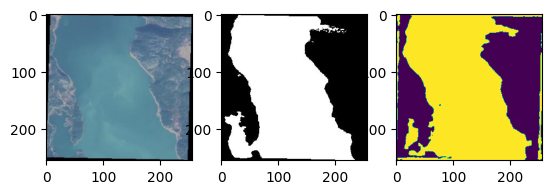

Epochs:23
Train_loss --> Dice: 0.153987896285559 BCE: 0.20493744803886665 
Valid_loss --> Dice: 0.1904674002102443 BCE: 0.2664657064846584


100%|██████████| 14/14 [00:04<00:00,  3.06it/s]


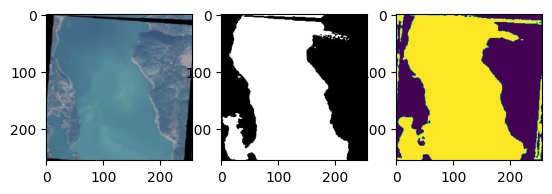

Epochs:24
Train_loss --> Dice: 0.1509180923825816 BCE: 0.20294989331772453 
Valid_loss --> Dice: 0.1904033592769078 BCE: 0.27119080615895136


100%|██████████| 14/14 [00:04<00:00,  3.06it/s]


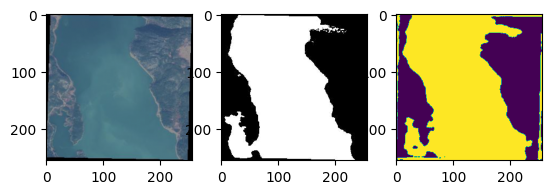

Epochs:25
Train_loss --> Dice: 0.15191005640908292 BCE: 0.206299101835803 
Valid_loss --> Dice: 0.18512434193066188 BCE: 0.2679594744529043
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.14it/s]


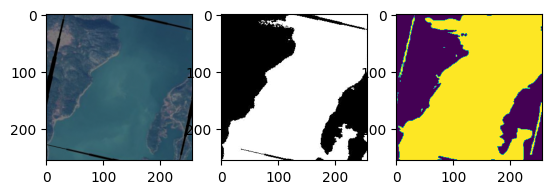

Epochs:26
Train_loss --> Dice: 0.14763802446817098 BCE: 0.199595134901373 
Valid_loss --> Dice: 0.18656989080565317 BCE: 0.2658151856490544
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.14it/s]


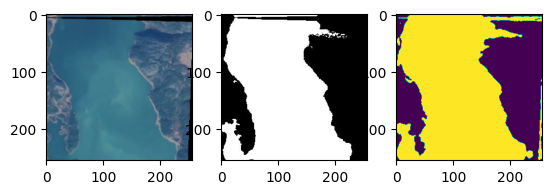

Epochs:27
Train_loss --> Dice: 0.1450593589167846 BCE: 0.19527444733600868 
Valid_loss --> Dice: 0.187788793018886 BCE: 0.27797257900238037


100%|██████████| 14/14 [00:04<00:00,  3.00it/s]


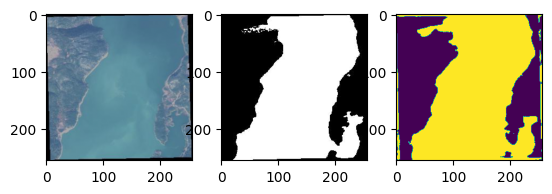

Epochs:28
Train_loss --> Dice: 0.14587714562290593 BCE: 0.19711384000746826 
Valid_loss --> Dice: 0.18380567005702428 BCE: 0.2651743324739592
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.11it/s]


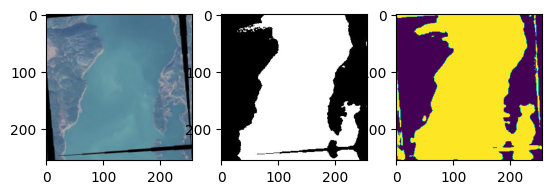

Epochs:29
Train_loss --> Dice: 0.14337970708545886 BCE: 0.1948465971570266 
Valid_loss --> Dice: 0.1831788080079215 BCE: 0.2591599641101701
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.00it/s]


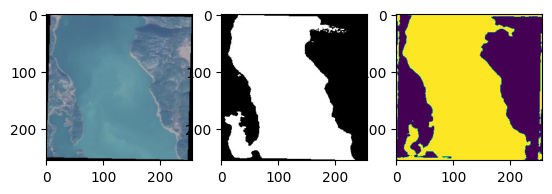

Epochs:30
Train_loss --> Dice: 0.14084626342120923 BCE: 0.1920498391907466 
Valid_loss --> Dice: 0.1817104390689305 BCE: 0.26885921508073807
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.03it/s]


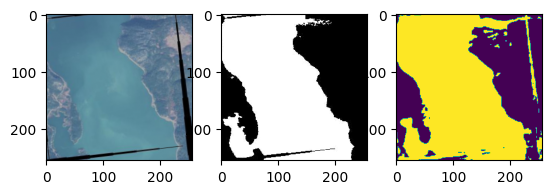

Epochs:31
Train_loss --> Dice: 0.14054933033491435 BCE: 0.1899641805181378 
Valid_loss --> Dice: 0.1800403552395957 BCE: 0.2580185319696154
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.10it/s]


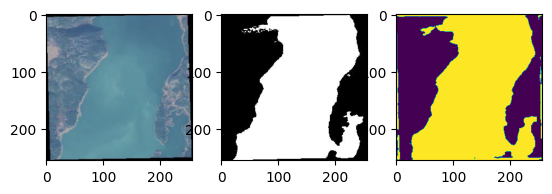

Epochs:32
Train_loss --> Dice: 0.13880090415477753 BCE: 0.18844045051618627 
Valid_loss --> Dice: 0.179431928055627 BCE: 0.26837217807769775
Model Saved


100%|██████████| 14/14 [00:04<00:00,  2.91it/s]


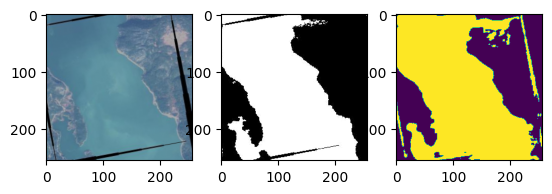

Epochs:33
Train_loss --> Dice: 0.13849504684147082 BCE: 0.18826136502780413 
Valid_loss --> Dice: 0.1785749069281987 BCE: 0.25534760845558985
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.17it/s]


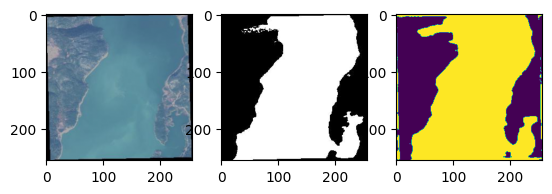

Epochs:34
Train_loss --> Dice: 0.13516064066635936 BCE: 0.183124853396102 
Valid_loss --> Dice: 0.1768910757132939 BCE: 0.26424775059734074
Model Saved


100%|██████████| 14/14 [00:04<00:00,  2.87it/s]


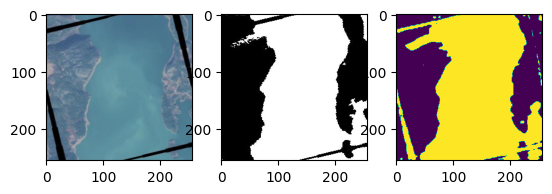

Epochs:35
Train_loss --> Dice: 0.13571273888412275 BCE: 0.1847743960587602 
Valid_loss --> Dice: 0.1764399196420397 BCE: 0.2627992810947554
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.12it/s]


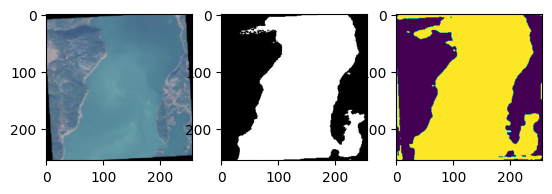

Epochs:36
Train_loss --> Dice: 0.13532405307418421 BCE: 0.18323080369124287 
Valid_loss --> Dice: 0.17879690868513926 BCE: 0.2656001203826496


100%|██████████| 14/14 [00:04<00:00,  2.95it/s]


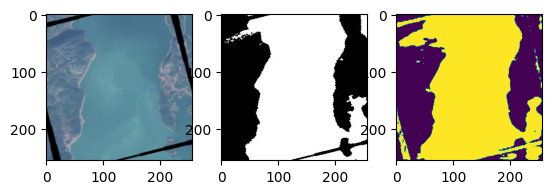

Epochs:37
Train_loss --> Dice: 0.13156144869954964 BCE: 0.17883228657669142 
Valid_loss --> Dice: 0.17376971670559474 BCE: 0.2654587892549379
Model Saved


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


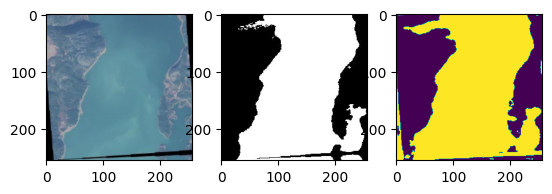

Epochs:38
Train_loss --> Dice: 0.12885939290649012 BCE: 0.17465735922910666 
Valid_loss --> Dice: 0.17252368586403982 BCE: 0.25653686055115293
Model Saved


100%|██████████| 14/14 [00:04<00:00,  2.95it/s]


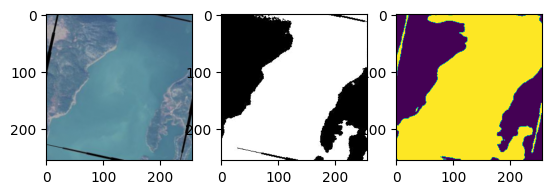

Epochs:39
Train_loss --> Dice: 0.13019438401648872 BCE: 0.1794322038951673 
Valid_loss --> Dice: 0.17475051539284842 BCE: 0.25452035133327755
Model Saved


100%|██████████| 14/14 [00:06<00:00,  2.22it/s]


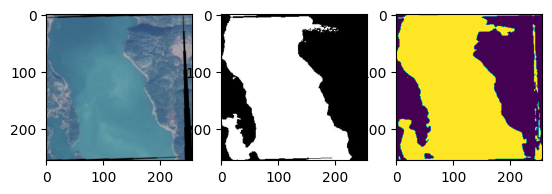

Epochs:40
Train_loss --> Dice: 0.12666954805976466 BCE: 0.1726052690493433 
Valid_loss --> Dice: 0.17631895627294267 BCE: 0.2641494518944195


100%|██████████| 14/14 [00:04<00:00,  2.89it/s]


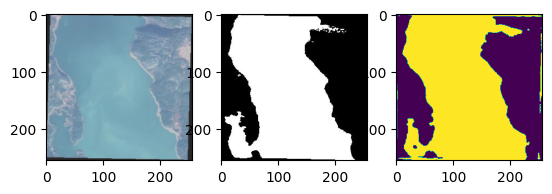

Epochs:41
Train_loss --> Dice: 0.12538728823787287 BCE: 0.1741996158502604 
Valid_loss --> Dice: 0.17059581194605147 BCE: 0.25999918367181507
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.05it/s]


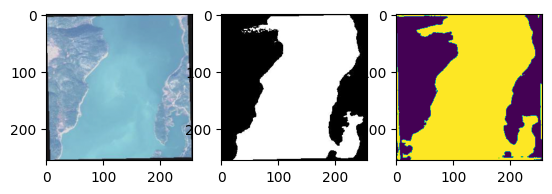

Epochs:42
Train_loss --> Dice: 0.1258627340981835 BCE: 0.17107675675498812 
Valid_loss --> Dice: 0.16997404609407699 BCE: 0.25611417314835955
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.18it/s]


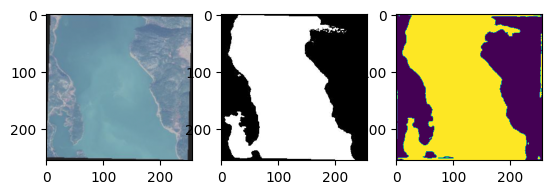

Epochs:43
Train_loss --> Dice: 0.12551929840916082 BCE: 0.17100469219057182 
Valid_loss --> Dice: 0.1707959004810878 BCE: 0.2551685561026846
Model Saved


100%|██████████| 14/14 [00:04<00:00,  2.92it/s]


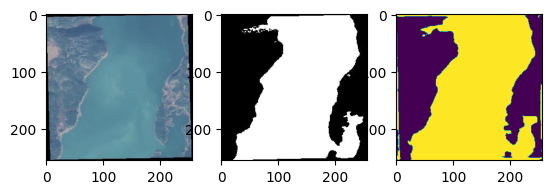

Epochs:44
Train_loss --> Dice: 0.12291848973224037 BCE: 0.16777443415240237 
Valid_loss --> Dice: 0.1675357690879277 BCE: 0.25872028512614115
Model Saved


100%|██████████| 14/14 [00:04<00:00,  3.06it/s]


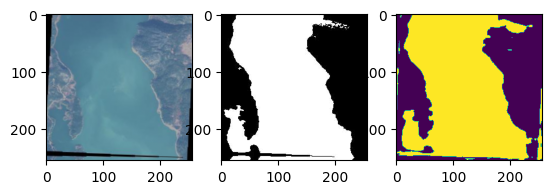

Epochs:45
Train_loss --> Dice: 0.12496007116217363 BCE: 0.17054560476619945 
Valid_loss --> Dice: 0.17108101078442164 BCE: 0.25672481315476553
Model Saved


In [8]:
best_val_dice_loss = np.Inf
best_val_bce_loss = np.Inf

for i in range(epochs):
    train_loss = train_fn(train_loader,model,optimizer)
    valid_loss = eval_fn(valid_loader,model)
    
    train_dice,train_bce = train_loss
    valid_dice,valid_bce = valid_loss
    print(f'Epochs:{i+1}\nTrain_loss --> Dice: {train_dice} BCE: {train_bce} \nValid_loss --> Dice: {valid_dice} BCE: {valid_bce}')
    if valid_dice < best_val_dice_loss or valid_bce < best_val_bce_loss:
        torch.save(model.state_dict(),'best_model.pt')
        print('Model Saved')
        best_val_dice_loss = valid_dice
        best_val_bce_loss = valid_bce


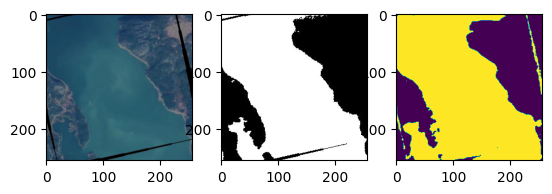

In [9]:
model.load_state_dict(torch.load('./best_model.pt'))

image,mask=next(iter(valid_loader))
image = image[sample_num]
mask = mask[sample_num]
logits_mask=model(image.to('cuda', dtype=torch.float32).unsqueeze(0))
pred_mask=torch.sigmoid(logits_mask)
pred_mask=(pred_mask > ratio)*1.0

f, axarr = plt.subplots(1,3) 
axarr[1].imshow(np.squeeze(mask.numpy()), cmap='gray')
axarr[0].imshow(np.transpose(image.numpy(), (1,2,0)))
axarr[2].imshow(np.transpose(pred_mask.detach().cpu().squeeze(0), (1,2,0)))